In [14]:
# hidden
import environment as env
env.initialize()

### Funciones de regresión para la caracterización de las variables no predominantes

##### NOTA: Este ejemplo es repetición de: [Funciones de regresión para la caracterización de las variables no predominantes](cl_regresion_01.ipynb) para la variable dirección media de procedencia de viento. En este ejemplo se utilizan los datos de viento con pretratamiento.

ste ejemplo continuará a partir de los datos temporales de altura de ola significante $H_s$ [Transformacion de los estados de las variables oceanograficas al emplazamiento](cl_transformacion_emplazamiento_01.ipynb), la serie de picos independientes de altura de ola significante $H_s$ obtenida en el apartado [Distribución de extremos de la variable predominante: Serie temporal de eventos extremos](cl_regimen_extremal_02.ipynb), el umbral elegido para el anañisis POT en el apartado [Distribución de extremos de la variable predominante: Serie temporal de picos sobre umbral (POT)](cl_regimen_extremal_03.ipynb) y los resultados del análisis extremal de $H_S$ para los periodos de retorno estudiados obtienidos en el apartado [Distribución de extremos de la variable principal y obtención de su valor para un determinado periodo de retorno](cl_regimen_extremal_04.ipynb).

Se utilizan los valores concomitantes del registro de eventos extremos de la altura de ola significante $H_s$
y se ajustan varios tipos de funciones de regresión. Es posible realizar ajustes utilizando funciones polinomiales de primer y segundo orden ('poli1', 'poli2'), potenciales de primer y segundo orden ('pote1, pote2'), hiperbólicas de primer y segundo orden ('pab1, pab2') y exponenciales de primer y segundo orden ('exp1, exp2').

Las funciones que se utilizan son:

- clima_maritimo.clima_maritimo.fdist.utils.picos_umb
- clima_maritimo.clima_maritimo.fdist.regimen_conjunto.regresion
- clima_maritimo.graficas.plot_regresion.ajustes_sobre_umbral

In [15]:
# imports Anaconda
from __future__ import division
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# imports ROM 1.1
from clima_maritimo.clima_maritimo.fdist import utils, regimen_conjunto
from clima_maritimo.graficas import plot_regresion

dir_data = os.path.join(env.data_path, 'clima')

df = pd.read_pickle(os.path.join(dir_data, 'cadiz_hs_sim_emp.pkl'))  
df_picos = pd.read_pickle(os.path.join(dir_data, 'cadiz_hs_sim_picos.pkl'))
umbral = np.load(os.path.join(dir_data, 'umbral_def_hs_sim_pot.npy'))
tit_pp = 'Hs'
lab_pp = '$H_s$ (m)'
df_out_pp = pd.read_pickle(os.path.join(dir_data, 'out_reg_extremal__' + tit_pp + '_tr.pkl'))

# Se carga de archivo el datframe con los datos de la variable no predominante
df_sec = pd.read_pickle(os.path.join(dir_data, 'cadiz_dv_sim_pretrat.pkl'))  
nm_sec = df_sec.iloc[:, 0].name
tit_sec = 'Du'
lab_sec = r'$\theta_U$ ($^\circ$)'

Entradas de usuario:

- Tipo de funciones de regresión que se desean analizar $fun\_reg$.

In [16]:
fun_reg =['poli1', 'poli2', 'pote1', 'pote2']

La figura muestra los resultados del análisis de regresión con las funciones elegidas. Las líneas continuas son el valor medio del ajuste y las discontinuas, el intervalo de confianza, elegido con un nivel de significancia del 0.05. Si la variable no predominante es circular (dirección de procedencia de oleaje o viento), el análisis se realiza utilizando los rangos de las direcciones principales. También se permite que el usuario elija las direcciones que desea estudiar agregando una entrada a la función $regresion$.

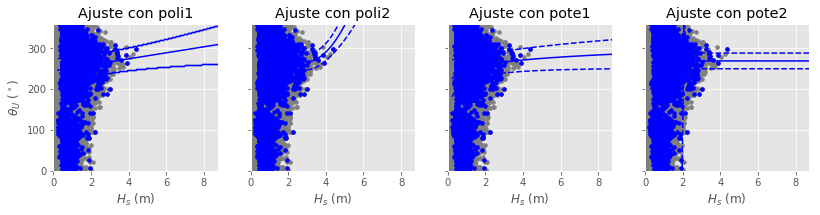

In [17]:
pos_picos_umb_pot = utils.picos_umb(df_picos.values, [umbral])
df_picos_umb_pot = df_picos.iloc[pos_picos_umb_pot[0], :]

df_picos_merge = pd.merge(df_picos, df_sec, left_index=True, right_index=True, how='inner')
df_merge = pd.merge(df, df_sec, left_index=True, right_index=True, how='inner')
df_merge.dropna(inplace=True)

reg = regimen_conjunto.regresion([df_picos_merge], df_picos, [umbral], [nm_sec], fun_reg, True)
reg.to_pickle(os.path.join(dir_data, 'regres_' + tit_pp + '_' + tit_sec + '.npy'))

plot_regresion.ajustes_sobre_umbral([df_picos_merge], df_merge, reg, [umbral], [nm_sec], fun_reg, [lab_pp, lab_sec])             


El usuario debe elegir la función elegida $fun\_reg\_def$ para obtener el valor medio y los intervalos de confianza del periodo pico $T_p$ para los periodos de retorno estudiados.

In [18]:
fun_reg_def = 'pote1'

In [19]:
# Si la variable no predominante es circular, los resultados se dan para las direcciones principales
if ((nm_sec == 'dh') | (nm_sec == 'dv')):
    ndirp = reg['ndirp' + nm_sec + fun_reg_def + str(umbral)][0]
    for kk in range(ndirp):
        out_x = reg['x' + nm_sec + fun_reg_def + str(umbral) + 'dir' + str(kk)]
        out_y = reg['y' + nm_sec + fun_reg_def + str(umbral) + 'dir' + str(kk)]
        out_y_inf = reg['yinf' + nm_sec + fun_reg_def + str(umbral) + 'dir' + str(kk)]
        out_y_sup = reg['ysup' + nm_sec + fun_reg_def + str(umbral) + 'dir' + str(kk)]

        if kk==0:
            for row_df in df_out_pp.itertuples():
                val_calc = getattr(row_df, tit_pp)
                vmed_calc = np.interp(val_calc, out_x, out_y)
                ciinf_calc = np.interp(val_calc, out_x, out_y_inf)
                cisup_calc = np.interp(val_calc, out_x, out_y_sup)

                df_out_pp.loc[row_df.Index, tit_sec] = vmed_calc
                df_out_pp.loc[row_df.Index, tit_sec + '_ci_sup'] = cisup_calc
                df_out_pp.loc[row_df.Index, tit_sec + '_ci_inf'] = ciinf_calc            
        else:
            df_out_pp_prv = df_out_pp.copy()
            for row_df in df_out_pp.itertuples():
                val_calc = getattr(row_df, tit_pp)
                vmed_calc = np.interp(val_calc, out_x, out_y)
                ciinf_calc = np.interp(val_calc, out_x, out_y_inf)
                cisup_calc = np.interp(val_calc, out_x, out_y_sup)

                df_out_pp_prv.loc[row_df.Index, tit_sec] = vmed_calc
                df_out_pp_prv.loc[row_df.Index, tit_sec + '_ci_sup'] = cisup_calc
                df_out_pp_prv.loc[row_df.Index, tit_sec + '_ci_inf'] = ciinf_calc
            
            df_out_pp_sec = df_out_pp.append(df_out_pp_prv)
            
        if ndirp == 1:
            df_out_pp_sec = df_out_pp

else:
    out_x = reg['x' + nm_sec + fun_reg_def + str(umbral)]
    out_y = reg['y' + nm_sec + fun_reg_def + str(umbral)]
    out_y_inf = reg['yinf'+ nm_sec + fun_reg_def + str(umbral)]
    out_y_sup = reg['ysup' + nm_sec + fun_reg_def + str(umbral)]

    for row_df in df_out_pp.itertuples():
        val_calc = getattr(row_df, tit_pp)
        vmed_calc = np.interp(val_calc, out_x, out_y)
        ciinf_calc = np.interp(val_calc, out_x, out_y_inf)
        cisup_calc = np.interp(val_calc, out_x, out_y_sup)
        
        df_out_pp.loc[row_df.Index, tit_sec] = vmed_calc
        df_out_pp.loc[row_df.Index, tit_sec + '_ci_sup'] = cisup_calc
        df_out_pp.loc[row_df.Index, tit_sec + '_ci_inf'] = ciinf_calc
        
    df_out_pp_sec = df_out_pp
    
# Guardar html y df
r_ds = os.path.join(env.output_path, 'clima', 'out_reg_extremal__' + tit_pp + '_' + tit_sec + '_tr.html')
df_out_pp_sec.to_html(r_ds, sparsify=False)

df_out_pp_sec.to_pickle(os.path.join(dir_data, 'out_reg_extremal__' + tit_pp + '_' + tit_sec + '_tr.pkl'))

# Mostrar en pantalla
HTML(filename=r_ds)